# Memory Leak Detection 

In [1]:
import sys
sys.path.append('../')
from mem_leak_detection import MemLeakDetectionAlgorithm
from mem_leak_detection import MemLeakDetectionAlgorithmPolyFit
from mem_leak_detection import MemLeakDetectionAlgorithmChangePoints
from mem_leak_detection import Precog
import pandas as pd
# required only for ploting
import matplotlib.pyplot as plt
%matplotlib inline 
from pylab import rcParams
rcParams['figure.figsize']= 15,6
import xlrd

In [2]:
import glob

In [3]:
path = '/mnt/datasets/metrics/memleak_negative'
memleak_negative_files = [f for f in glob.glob(path + "**/**/*.xlsx", recursive=True)]
path2 = '/mnt/datasets/metrics/memleak_positive'
memleak_positive_files = [f for f in glob.glob(path2 + "**/**/*.xlsx", recursive=True)]

In [4]:
len(memleak_negative_files)

55

-yellow graphs are good(true negative) <br>
-blue are false negative


/mnt/datasets/iforesight/metrics/memleak_negative/sn_e91723af-897e-4a79-bef9-0a3b7ac3a92d/mem0520_7d.xlsx
/mnt/datasets/iforesight/metrics/memleak_negative/sn_594f5bc8-399b-4912-a45d-3cbf16482157/mem0520_7d.xlsx
/mnt/datasets/iforesight/metrics/memleak_negative/sn_22018a21-8ff6-439d-b503-6de6fee64305/mem0520_7d.xlsx
/mnt/datasets/iforesight/metrics/memleak_negative/sn_1e2cfcf8-71d9-4f9f-94b5-9b8e55a21c75/mem0520_7d.xlsx
/mnt/datasets/iforesight/metrics/memleak_negative/memleak67/cmc_false_positive.xlsx
/mnt/datasets/iforesight/metrics/memleak_negative/memleak66/cdn_false_positive.xlsx
/mnt/datasets/iforesight/metrics/memleak_negative/memleak65/FPdata10.xlsx
/mnt/datasets/iforesight/metrics/memleak_negative/memleak64/FPdata5.xlsx
/mnt/datasets/iforesight/metrics/memleak_negative/memleak63/FPdata12.xlsx
/mnt/datasets/iforesight/metrics/memleak_negative/memleak62/FPdata7.xlsx
/mnt/datasets/iforesight/metrics/memleak_negative/memleak61/FPdata13.xlsx
/mnt/datasets/iforesight/metrics/memleak

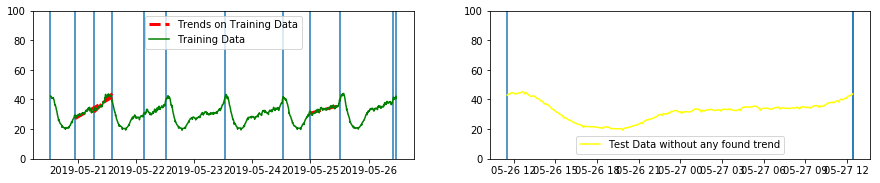

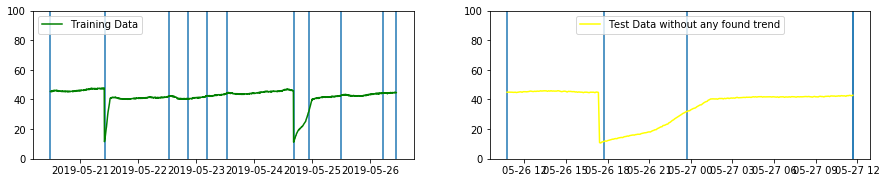

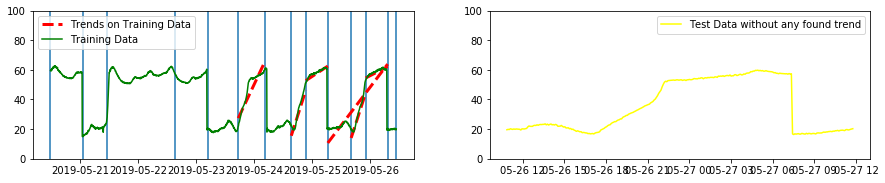

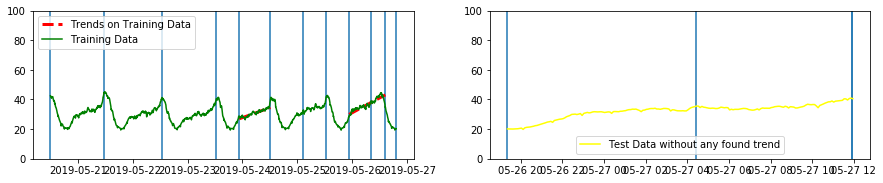

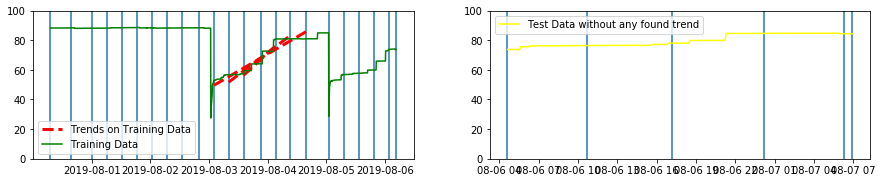

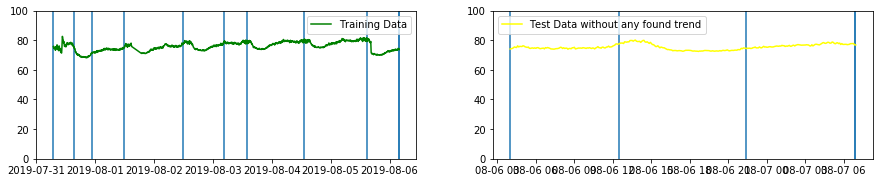

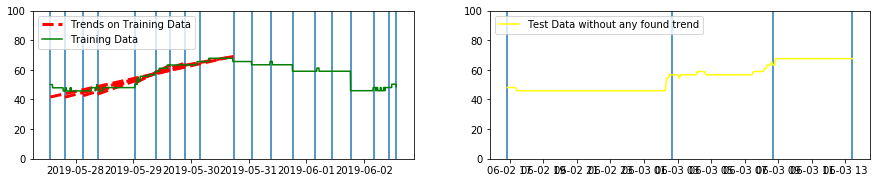

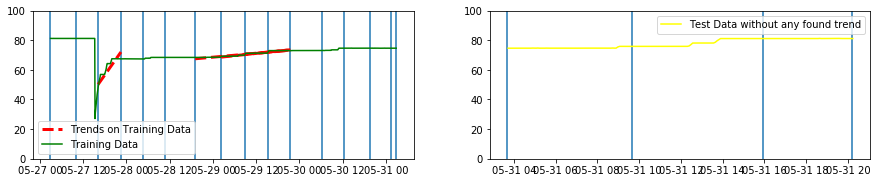

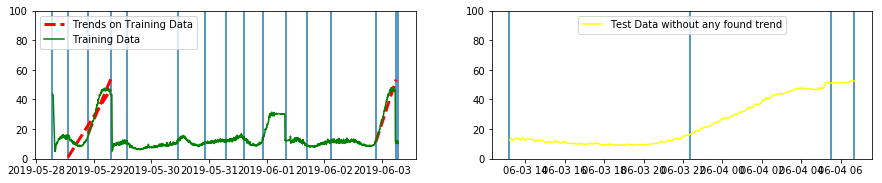

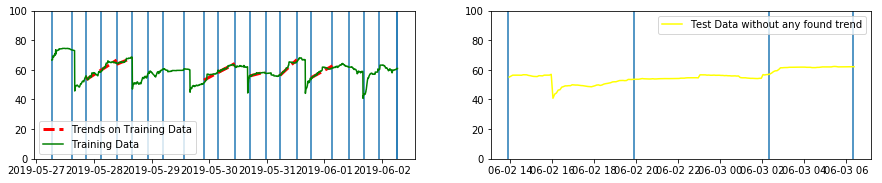

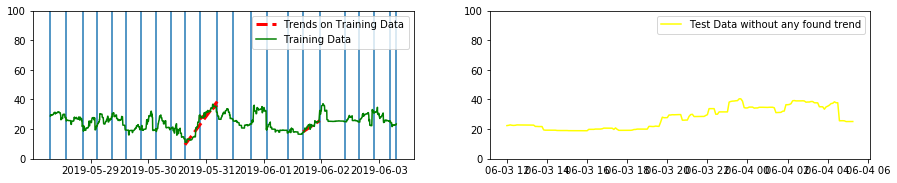

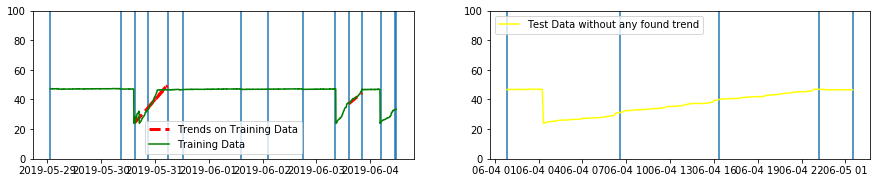

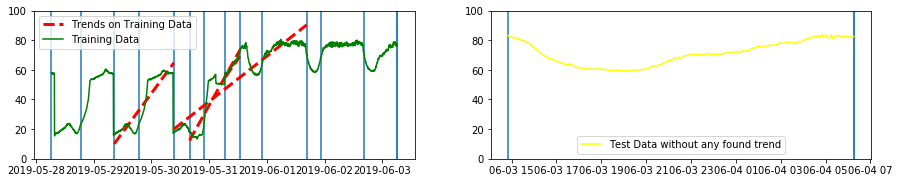

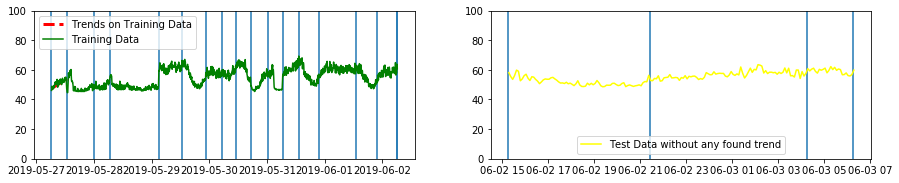

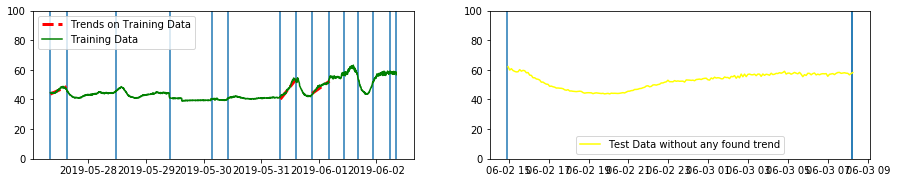

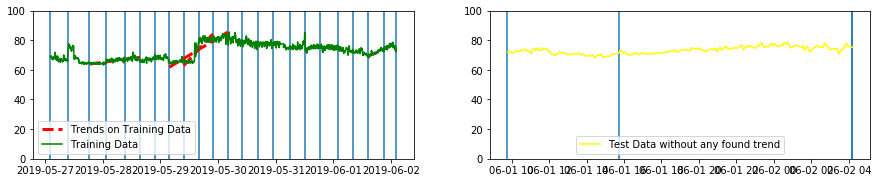

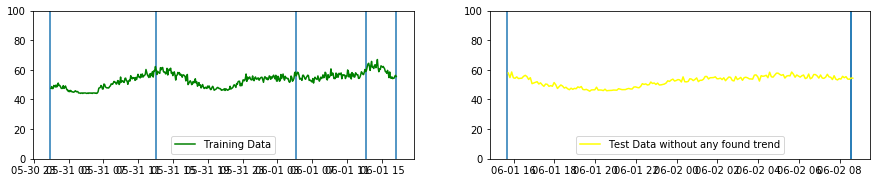

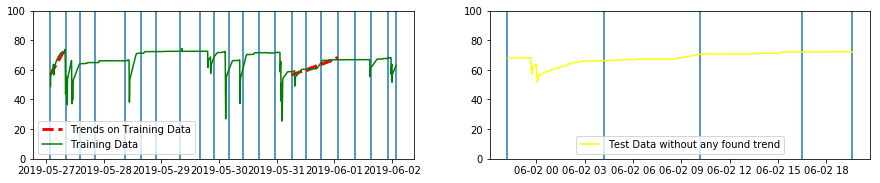

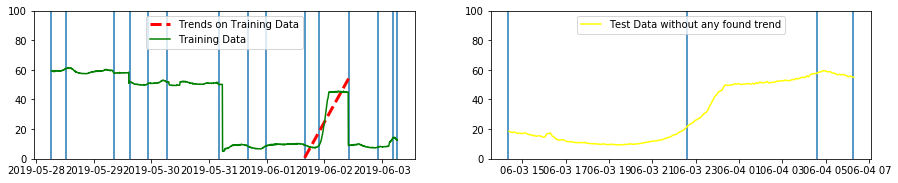

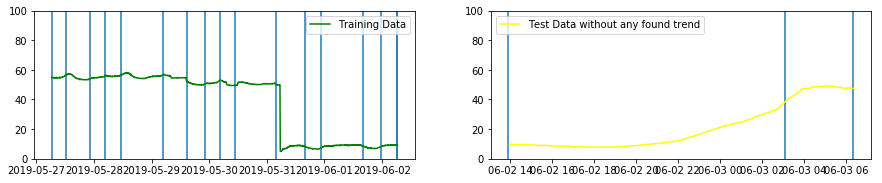

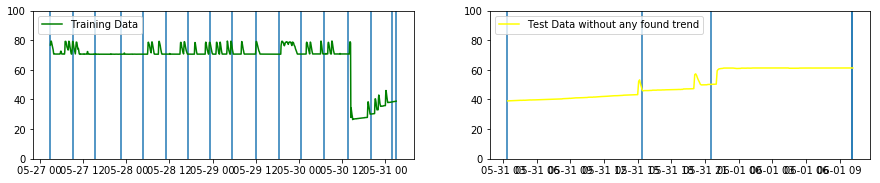

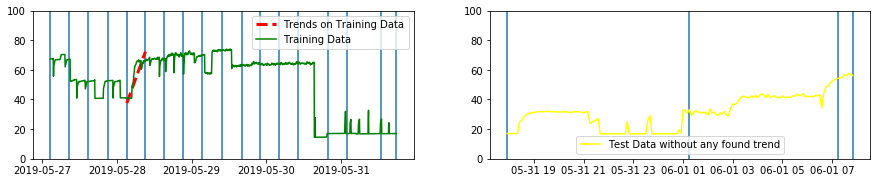

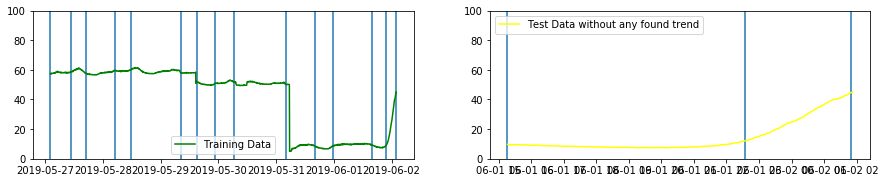

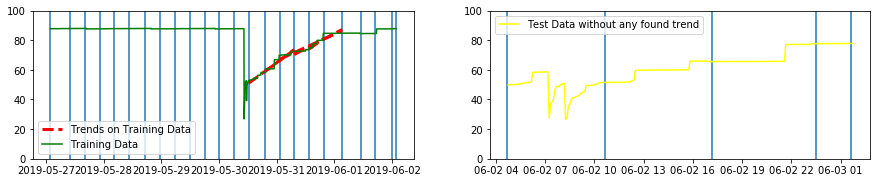

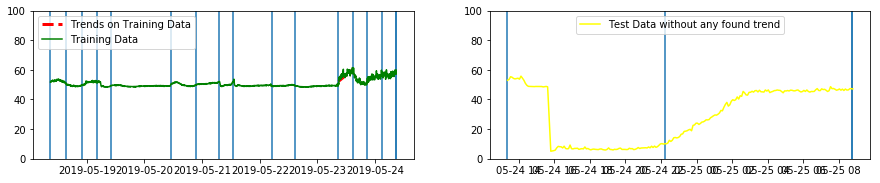

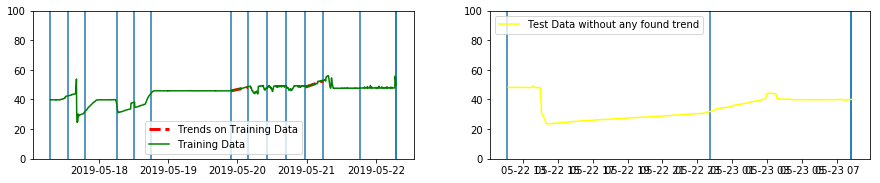

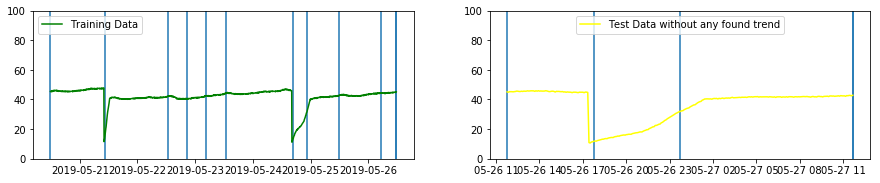

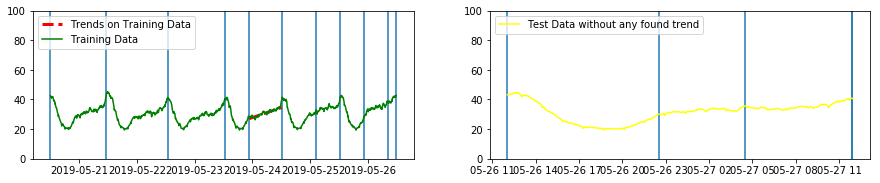

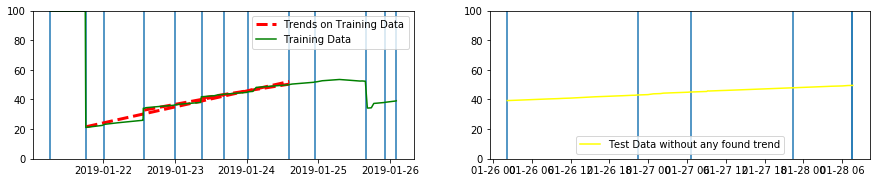

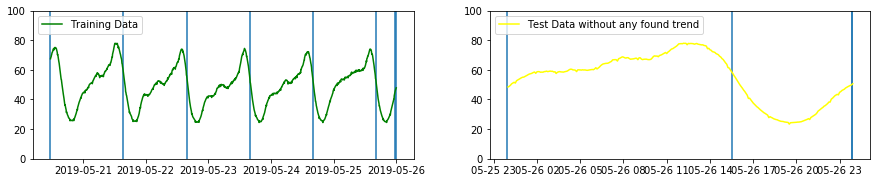

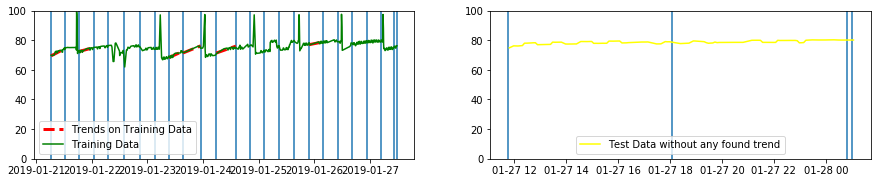

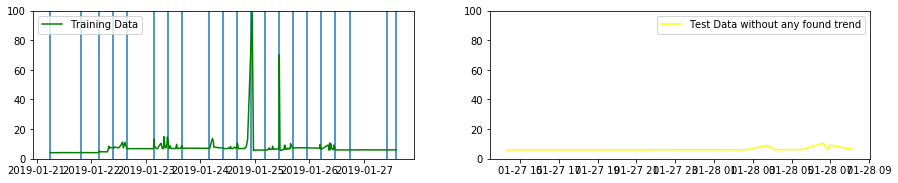

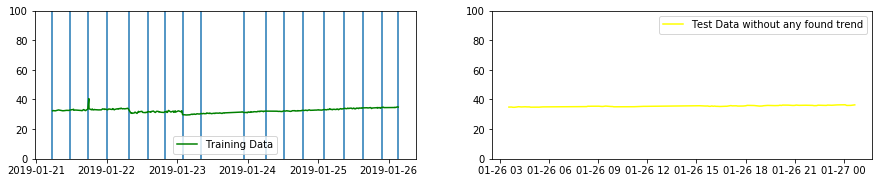

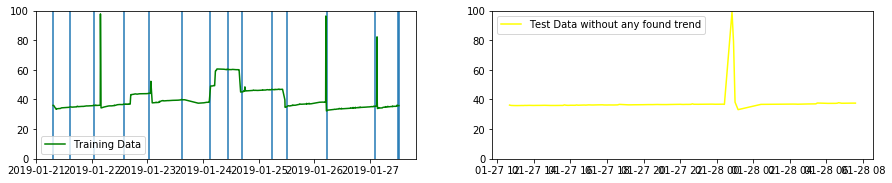

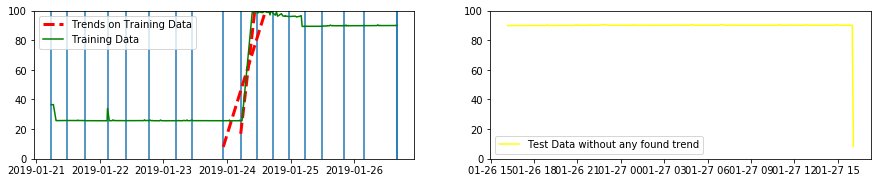

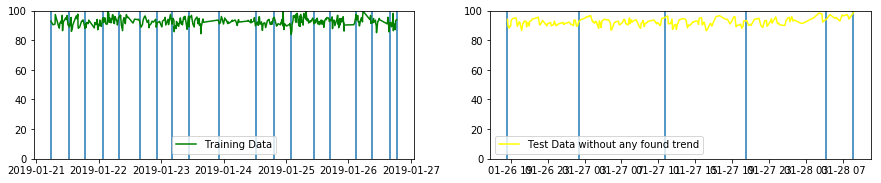

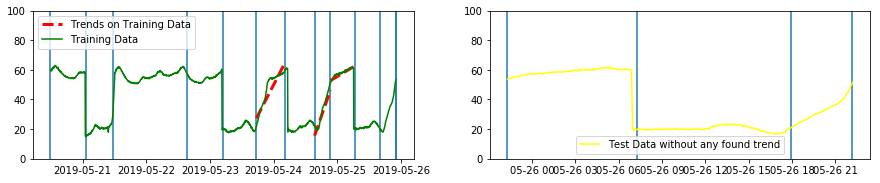

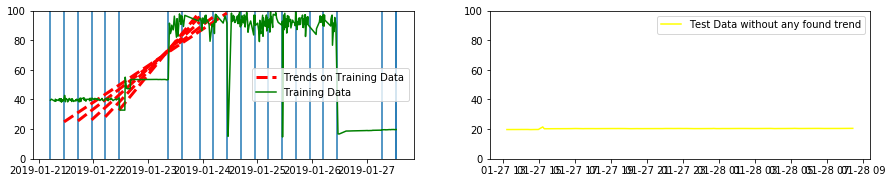

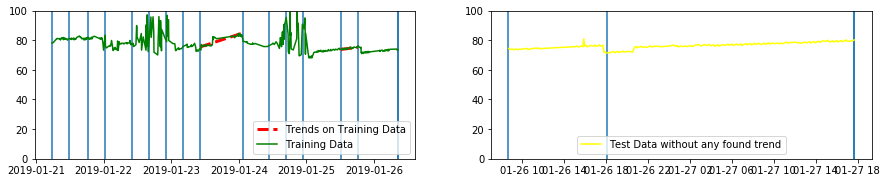

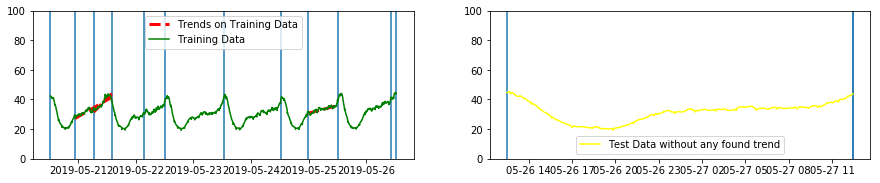

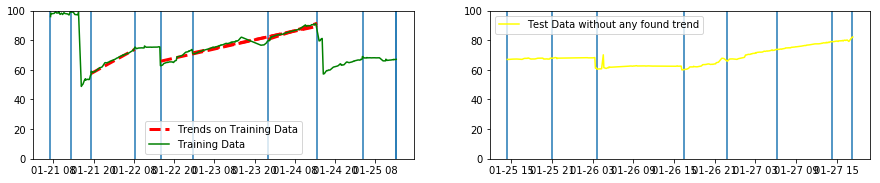

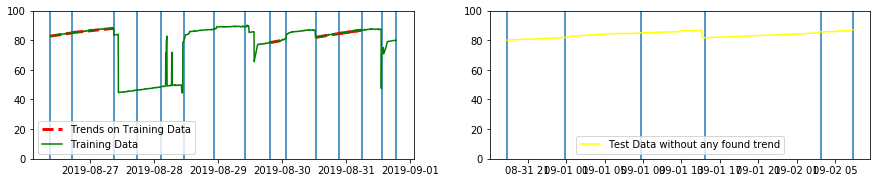

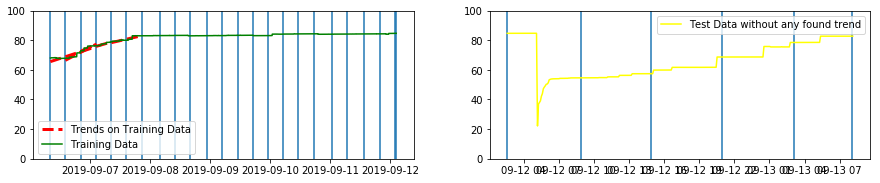

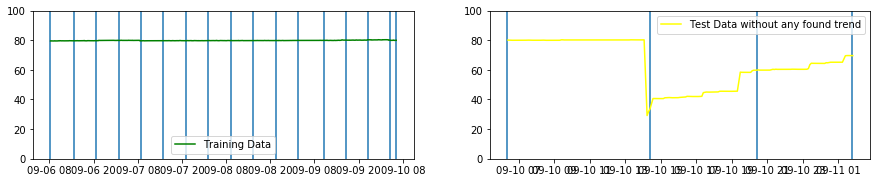

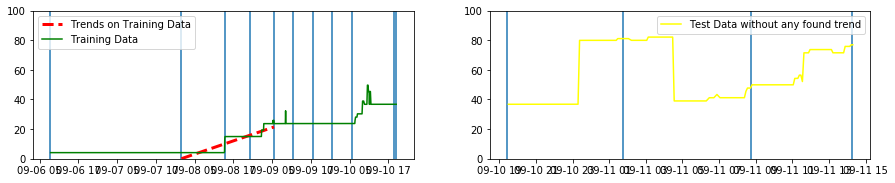

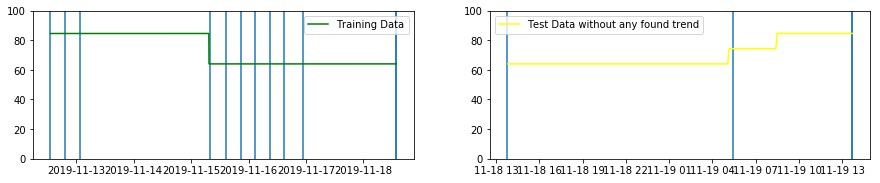

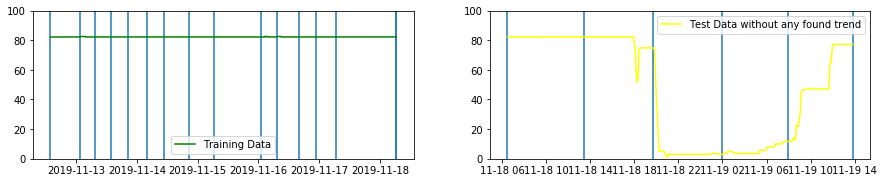

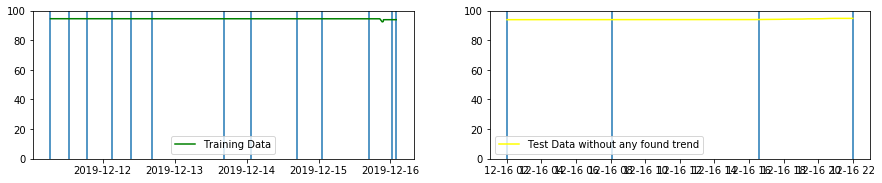

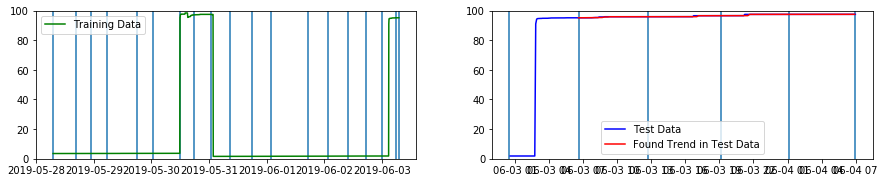

In [5]:
i = 0
for file in memleak_negative_files:
    i = i +1
    if file =="#####.xlsx":
        continue
    if(len(pd.ExcelFile(file).sheet_names) > 1):
        xls = xlrd.open_workbook(file, on_demand=True)
        print(file)
        if "Train Data" in xls.sheet_names():
            dataset_train = pd.read_excel(file, "Train Data")
        elif "Sheet1" in xls.sheet_names():
            dataset_train = pd.read_excel(file, "Sheet1")
        else:
            dataset_train = pd.read_excel(file, "Data Train")
        dataset_test = pd.read_excel(file, "Test Data")
        dataset_train['Timestamp'] =  pd.to_datetime(dataset_train['Timestamp'], unit='s')
        dataset_test['Timestamp'] =  pd.to_datetime(dataset_test['Timestamp'], unit='s')
        dataset_train.set_index('Timestamp', inplace=True)
        dataset_test.set_index('Timestamp', inplace=True)
        #dataset = dataset.resample("1ms").median()
        #dataset.dropna(inplace=True)
        p1 = Precog()
        p1 = p1.fit(dataset_train.Value)
        plt.figure(figsize=(15,6))
        plt.subplot(221)
        plt.ylim(0,100)
        for xc in p1.change_point_indexes:
            plt.axvline(x=xc)
        for series in p1.fit_trends:
            plt.plot(series,'--', linewidth=3, color='red', label='Trends on Training Data')
        plt.plot(dataset_train.Value, color='green', label='Training Data' )
        plt.legend()
        #plt.scatter(dataset.query('label == 1').index, dataset.query('label == 1').mem_util_percent.values,marker='o', color='red' )
        
        points = p1.predict(dataset_test.Value)
        if(len(points) > 0):
            timestamps = [pd.to_datetime(x.timestamp, unit="ms") for x in points[0].points]
            anomalies = [x.value for x in points[0].points]
            df = pd.DataFrame({'timestamp': timestamps, 'values': anomalies})
            df.set_index("timestamp", inplace=True)    
            
            plt.subplot(222) 
            plt.ylim(0,100)
            for xc in p1.change_point_indexes_predict:
                plt.axvline(x=xc)
            #plt.plot(p1.prediction_trend,'--', linewidth=3, color='red', label='Prediction Trend on Test Data')
            plt.plot(dataset_test.Value, color='blue', label='Test Data')
            plt.plot(df, color='red', label='Found Trend in Test Data')
            plt.legend()
            #plt.scatter(dataset.query('label == 1').index, dataset.query('label == 1').mem_util_percent.values,marker='o', color='red' )
        else:
            plt.subplot(222) 
            plt.ylim(0,100)
            for xc in p1.change_point_indexes_predict:
                plt.axvline(x=xc)
            plt.plot(dataset_test.Value, color='yellow', label='Test Data without any found trend' )  
            plt.legend()
    else:
        continue